# Co-contraction Analysis

## NOTE: Data is not currently shared. This code is only provided for reference.

Co-contraction analysis uses the pre-processed coactivations from `step1` and used `SMART` toolbox to smoothly downsample the results to get only a handful datapoints.

This script re-produces Figures 4 and 5 of the manuscript

In [1]:
# Import libraries and setup values
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import plotly.graph_objects as go
import ray
import seaborn as sns
from matplotlib.colors import to_rgb as rgb
from plotly.subplots import make_subplots

import EssentialEMGFuncs as ess
import lineNdots as lnd
import SMART_Funcs as SF

ray.init(dashboard_host='127.0.0.1', ignore_reinit_error=True)
save_fig, save_stats, save_data = False, False, False
plot_fig = True

/opt/homebrew/anaconda3/envs/torch-beta/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
2022-11-11 17:18:30,519	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [2]:
# Setup variables
SUBJS = {'young': ["PS04", "PS05", "PS06", "PS07", "PS15", "PS16", "PS17", "PS18", "PS19", "PS20", "PS21", "PS22",
                   "PS23", "PS24", "PS25", "PS26", "PS27"],
         'old': ["PS08", "PS09", "PS10", "PS28", "PS29", "PS31", "PS32", "PS33", "PS34", "PS35", "PS36"]
         }
CONDS = ['LME', 'LEI', 'RME', 'REI']
BLOCKS = {'pre': [0], 'pert': [1, 3], 'catch': [2], 'post': [4]}
DATA_PATH = './data/emg/'
RESMAPLED_DATA = 'gaussian-resmped_young-old_raw-data.pickle'
COACTIVATION_DATA = 'coactivation_young-and-old_resampled_perturb-recovery-steps.pickle'
STEP_DATA = 'stepping_time_young-and-old.pickle'
TESTS = {'perturbed': ['start', 'other'], 'recovery': ['other', 'end']}
TARGET_PAIR = {
    'left_step': {
        'LTA-LSO': ['LSO', 'LTA'],
        'LRF-LST': ['LRF', 'LST'],
        'LAD-LPD': ['LPD', 'LAD'],
        'RTA-RSO': ['RTA', 'RSO'],
        'RRF-RST': ['RST', 'RRF'],
        'RAD-RPD': ['RAD', 'RPD']
    },
    'right_step': {
        'LTA-LSO': ['LTA', 'LSO'],
        'LRF-LST': ['LST', 'LRF'],
        'LAD-LPD': ['LAD', 'LPD'],
        'RTA-RSO': ['RSO', 'RTA'],
        'RRF-RST': ['RRF', 'RST'],
        'RAD-RPD': ['RPD', 'RAD']
    }
}
TP_NAMES = list(TARGET_PAIR['left_step'])

# load the step times
step_time = pkl.load(open(DATA_PATH + 'group_response/' + STEP_DATA, 'rb'))
# load coactivation data from step 1
coactivation = pkl.load(open(DATA_PATH + 'group_response/' + COACTIVATION_DATA, 'rb'))


## convert the co-contraction data to the SMART format
Using the SMART toolbox and working with the kernel and step size we can find the suitable outputs for our analysis. 

In [3]:
# Convert the coactivation format to SMART short format
smart_cols = ['subj_no', 'time'] + [p for p in TP_NAMES]
metric_short = {t: {a: {c: {b: pd.DataFrame(columns=smart_cols) for b in BLOCKS} for c in CONDS} for a in SUBJS}
                for t in TESTS}

for t in TESTS:
    for a in SUBJS:
        for c in CONDS:
            for b in BLOCKS:
                for s in SUBJS[a]:
                    try:
                        strides = coactivation[t][c][s][b].index.tolist()
                        temp_dict = {'subj_no': s, 'time': step_time[c][s].loc[strides, 'start'].values,
                                     **{p: coactivation[t][c][s][b][p].values for p in TP_NAMES}}
                        metric_short[t][a][c][b] = pd.concat(
                            (metric_short[t][a][c][b], pd.DataFrame([temp_dict])), ignore_index=True)
                    except Exception:
                        print(f'there was a problem in {a}:{s}_{c}_{b}')

Note that we use `Ray` to make the processing parallel. If you choose to cahgne the `step_size` to a smaller number, it can take up to a couple of minutes (based on your computation power), to run the following steps

In [4]:
# Let's do the SMART thing
time_var = 'time'  # short format file spec
# min and max time stamps for the different blocks
time_lim = {'pre': [0, 120], 'pert': [120, 480], 'catch': [120, 480], 'post': [480, 600]}
kernel_size, step_size = 16, 60  # smoothing params
n_perms, baseline = 1000, 1  # permutation params
sig_level = 0.05  # stats params
l_color = {'pre': rgb('black'), 'pert': rgb('green'), 'catch': rgb('darkviolet'), 'post': rgb('dodgerblue')}
# plotting params. "l": line, "m": marker, "hist_res": histogram resolution for permutation the distribution plot.
l_width, ma_offset, m_size, label_size, hist_res = 2, 0.75, 10, 20, 100

# pre-allocate variables
no_subjs = {a: {c: {b: len(metric_short[t][a][c][b]) for b in BLOCKS} for c in CONDS} for a in SUBJS}
all_times = {a: {c: {b: np.hstack(metric_short[t][a][c][b][time_var]) for b in BLOCKS} for c in CONDS} for a in SUBJS}
time_vect = {b: np.arange(time_lim[b][0], time_lim[b][1], step_size) for b in BLOCKS}
timeVect_ray = {b: ray.put(time_vect[b]) for b in BLOCKS}

# smoothed data and weights.
sm_data, sm_weights = [{t: {a: {c: {b: {p: np.zeros((no_subjs[a][c][b], len(time_vect[b]))) for p in TP_NAMES}
                                    for b in BLOCKS} for c in CONDS} for a in SUBJS} for t in TESTS}
                       for _ in range(2)]

# permutation data weights.
perm_d1, perm_w1, perm_d2, perm_w2 = [{t: {a: {c: {b: {p: np.zeros((no_subjs[a][c][b], len(time_vect[b]), n_perms))
                                                      for p in TP_NAMES} for b in BLOCKS} for c in CONDS}
                                          for a in SUBJS} for t in TESTS} for _ in range(4)]

# ray smoothing and permute identifiers.
sm_id, pm_id = [{t: {a: {c: {b: {p: {i: [] for i in np.arange(no_subjs[a][c][b])} for p in TP_NAMES} for b in BLOCKS}
                         for c in CONDS} for a in SUBJS} for t in TESTS} for _ in range(2)]

par_smooth = ray.remote(SF.gaussSmooth)
par_permute = ray.remote(SF.permute)
# run smoothing and permutation
for t in TESTS:
    for a in SUBJS:
        for c in CONDS:
            for b in BLOCKS:
                for p in TP_NAMES:
                    for i in np.arange(no_subjs[a][c][b]):
                        # Sanity Check
                        # sm_data[t][a][c][b][p][i,:], sm_weights[t][a][c][b][p][i, :] = SF.gaussSmooth(
                        #     metric_short[t][a][c][b][time_var][i], metric_short[t][a][c][b][p][i], time_vect[b],
                        #     kernel_size)
                        # (perm_d1[t][a][c][b][p][i, :, :], perm_w1[t][a][c][b][p][i, :, :],
                        #  perm_d2[t][a][c][b][p][i, :, :], perm_w2[t][a][c][b][p][i, :, :]) = SF.permute(
                        #     metric_short[t][a][c][b][time_var][i], metric_short[t][a][c][b][p][i], newX=time_vect[b],
                        #     sigma=kernel_size, nPerms=n_perms, baseline=baseline)

                        sm_id[t][a][c][b][p][i] = par_smooth.remote(
                            metric_short[t][a][c][b][time_var][i], metric_short[t][a][c][b][p][i], timeVect_ray[b],
                            kernel_size)
                        pm_id[t][a][c][b][p][i] = par_permute.remote(metric_short[t][a][c][b][time_var][i],
                            metric_short[t][a][c][b][p][i], newX=timeVect_ray[b], sigma=kernel_size, nPerms=n_perms,
                            baseline=baseline)


In [5]:
# Get the Ray results
for t in TESTS:
    for a in SUBJS:
        for c in CONDS:
            for b in BLOCKS:
                for p in TP_NAMES:
                    for i in np.arange(no_subjs[a][c][b]):
                        try:
                            sm_id[t][a][c][b][p][i] = ray.get(sm_id[t][a][c][b][p][i])
                            pm_id[t][a][c][b][p][i] = ray.get(pm_id[t][a][c][b][p][i])
                            sm_data[t][a][c][b][p][i, :], sm_weights[t][a][c][b][p][i, :] = [
                                sm_id[t][a][c][b][p][i][k] for k in range(2)]
                            (perm_d1[t][a][c][b][p][i, :, :], perm_w1[t][a][c][b][p][i, :, :],
                             perm_d2[t][a][c][b][p][i, :, :], perm_w2[t][a][c][b][p][i, :, :]) = [
                                pm_id[t][a][c][b][p][i][k] for k in range(4)]
                        except Exception:
                            print(f'smoothing failed for {a}_subject{i}_{c}_{b}_{t}')

del sm_id, pm_id  # deleting is required to free up space from RAY processing


In [6]:
# Quantify weighted coactivation average and the CI
weighted_average, weight_sum, sigInd_inClust, ensemTval_inClust, conf95, perm_distr, sig_ther, stat_id = [{t: {a: {c:
    {b: [] for b in BLOCKS} for c in CONDS} for a in SUBJS} for t in TESTS} for _ in range(8)]
stats = True  # whether to run stats or not. Needed if you want to have rugplots


@ray.remote
def run_stats(sm_data, sm_weights, analysis_type, sig_level, stats=False, baseline=0, perm_d1=None, perm_d2=None,
              perm_w1=None, perm_w2=None):
    weighted_average, weights, sigInd_inClust, ensemTval_inClust, conf95, perm_distr, sig_ther = [
        {t: [] for t in analysis_type} for _ in range(7)]
    for t in analysis_type:
        weighted_average[t], weights[t] = np.average(sm_data[t], weights=sm_weights[t], axis=0, returned=True)
        conf95[t] = ess.bootstrap_confidence_interval(
            sm_data[t], weights=sm_weights[t], stat_fun='weighted_average', ci=1 - sig_level)
        if stats:
            sigInd_inClust[t], ensemTval_inClust[t] = SF.clusterStat_oneSamp(
                sm_data[t], sm_weights[t], baseline, sig_level)
            perm_distr[t] = SF.permuteClusterStat(perm_d1[t], perm_d2[t], perm_w1[t], perm_w2[t], sig_level)
            sig_ther[t] = np.percentile(perm_distr[t], 100 - (sig_level * 100))
    if not stats:
        return weighted_average, weights, conf95
    else:
        return weighted_average, weights, conf95, sigInd_inClust, ensemTval_inClust, perm_distr, sig_ther


for t in TESTS:
    for a in SUBJS:
        for c in CONDS:
            for b in BLOCKS:
                if not stats:
                    stat_id[t][a][c][b] = run_stats.remote(
                        sm_data[t][a][c][b], sm_weights[t][a][c][b], TP_NAMES, sig_level)
                else:
                    stat_id[t][a][c][b] = run_stats.remote(
                        sm_data[t][a][c][b], sm_weights[t][a][c][b], TP_NAMES,
                        sig_level, stats=stats, baseline=1,
                        perm_d1=perm_d1[t][a][c][b],
                        perm_d2=perm_d2[t][a][c][b],
                        perm_w1=perm_w1[t][a][c][b],
                        perm_w2=perm_w2[t][a][c][b])
for t in TESTS:
    for a in SUBJS:
        for c in CONDS:
            for b in BLOCKS:
                stat_id[t][a][c][b] = ray.get(stat_id[t][a][c][b])
                if not stats:
                    weighted_average[t][a][c][b], weight_sum[t][a][c][b], conf95[t][a][c][b] = [
                        stat_id[t][a][c][b][i] for i in range(3)]
                else:
                    (weighted_average[t][a][c][b], weight_sum[t][a][c][b], conf95[t][a][c][b],
                     sigInd_inClust[t][a][c][b], ensemTval_inClust[t][a][c][b], perm_distr[t][a][c][b],
                     sig_ther[t][a][c][b]) = [stat_id[t][a][c][b][i] for i in range(7)]

del stat_id

## make heatmap with the CI index.
CI index deviation from "one" is the most important feature of the CI. We can summarize it in a heatmap with rows that are representative of the muscle pairs and steps and the columns that are representative of time. Similar to Iturralde and Torres-Oviedo 2019 eNeuro. Here, each column is a minute.
To get per-minute data, we just need to change the kernel size in the SMART section of the code above. After that, the following lines are a shear reorganization of the data.

In [7]:
NUM_COL = 10  # one column per minute
ci_maps = {a: {c: np.zeros([len(TP_NAMES) * len(TESTS), NUM_COL]) for c in CONDS} for a in SUBJS}
DES_POINTS = {'pre': 2, 'pert': 6, 'catch': 6, 'post': 2}

for a in SUBJS:
    for c in CONDS:
        for i, p in enumerate([(x, y) for x in TESTS for y in TP_NAMES]):
            count = 0
            for b in BLOCKS:
                if b != 'catch':
                    ci_maps[a][c][i, count: count + DES_POINTS[b]] = weighted_average[p[0]][a][c][b][p[1]]
                    count += DES_POINTS[b]

# A similar approach is needed for the significance.
# The difference is that the significance does not have the raw array. So we need to first make it.
significance = {t: {a: {c: {b: {p: np.zeros_like(weighted_average[t][a][c][b][p]) for p in TP_NAMES} for b in BLOCKS}
                        for c in CONDS} for a in SUBJS} for t in TESTS}

for t in TESTS:
    for a in SUBJS:
        for c in CONDS:
            for b in BLOCKS:
                for p in TP_NAMES:
                    for sdx, s in enumerate(
                            sigInd_inClust[t][a][c][b][p]):  # type: ignore
                        if ensemTval_inClust[t][a][c][b][p][sdx] > sig_ther[t][a][c][b][p]:  # type: ignore
                            significance[t][a][c][b][p][s] = 1

sig_maps, sigmaps_num = [{a: {c: np.zeros([len(TP_NAMES) * len(TESTS), NUM_COL]) for c in CONDS} for a in SUBJS}
                         for _ in range(2)]

for a in SUBJS:
    for c in CONDS:
        for i, p in enumerate([(x, y) for x in TESTS for y in TP_NAMES]):
            count = 0
            for b in BLOCKS:
                if b != 'catch':
                    sig_maps[a][c][i, count: count + DES_POINTS[b]] = significance[p[0]][a][c][b][p[1]]
                    count += DES_POINTS[b]
        sigmaps_num[a][c] = sig_maps[a][c].copy()
        sig_maps[a][c] = np.char.array(np.uint(sig_maps[a][c]), unicode=True, copy=True)
        sig_maps[a][c][sig_maps[a][c] == '1'] = '•'
        sig_maps[a][c][sig_maps[a][c] == '0'] = ' '

# it is easier to plot the dots w/ plotly
fig = make_subplots(len(CONDS), len(SUBJS), subplot_titles=[f'{x}_{y}' for x in CONDS for y in SUBJS])
y = [f'{r}_{t}' for r in ['p', 'r'] for t in TP_NAMES]
y.reverse()
for i, c in enumerate(CONDS):
    for j, a in enumerate(SUBJS):
        trace = go.Heatmap(
            z=np.flipud(ci_maps[a][c]),
            y=y, x=list(range(1, 11)),
            colorscale='rdbu', reversescale=True, zmin=.7, zmax=1.3, xgap=2, ygap=2,
            text=np.flipud(sig_maps[a][c]), texttemplate="%{text}",
            textfont={"size": 20, "color": "black"}
        )
        fig.add_trace(trace, row=i + 1, col=j + 1)
fig.update_layout(height=1600, width=1000, title_text='co-contraction index', font_family="Open Sans")
if plot_fig:
    fig.show()
if save_fig:
    fig.write_image(DATA_PATH + 'group_response/coContraction_index_heatmap.pdf')

# Seaborn plotting, not the easiest to put the dots on heatmap though.
# fig, ax = plt.subplots(len(CONDS), len(SUBJS), figsize=(9, 15), dpi=400, facecolor=None, )
# for i, c in enumerate(CONDS):
#     for j, a in enumerate(SUBJS):
#         temp_df = pd.DataFrame(ci_maps[a][c], index=tp_names+tp_names, columns=range(1,11))
#         sns.heatmap(temp_df,vmin=0.8, vmax=1.2, cmap='vlag', linewidths=0.5, ax= ax[i,j],
#                    cbar_kws={'orientation':'horizontal','location':'top','shrink':0.3,
#                   'ticks':[0.8,1,1.2],'anchor':(0,0)})
#         ax[i,j].set_title(f'{c}_{a}')

# fig.suptitle('co-contraction index')
# plt.tight_layout()

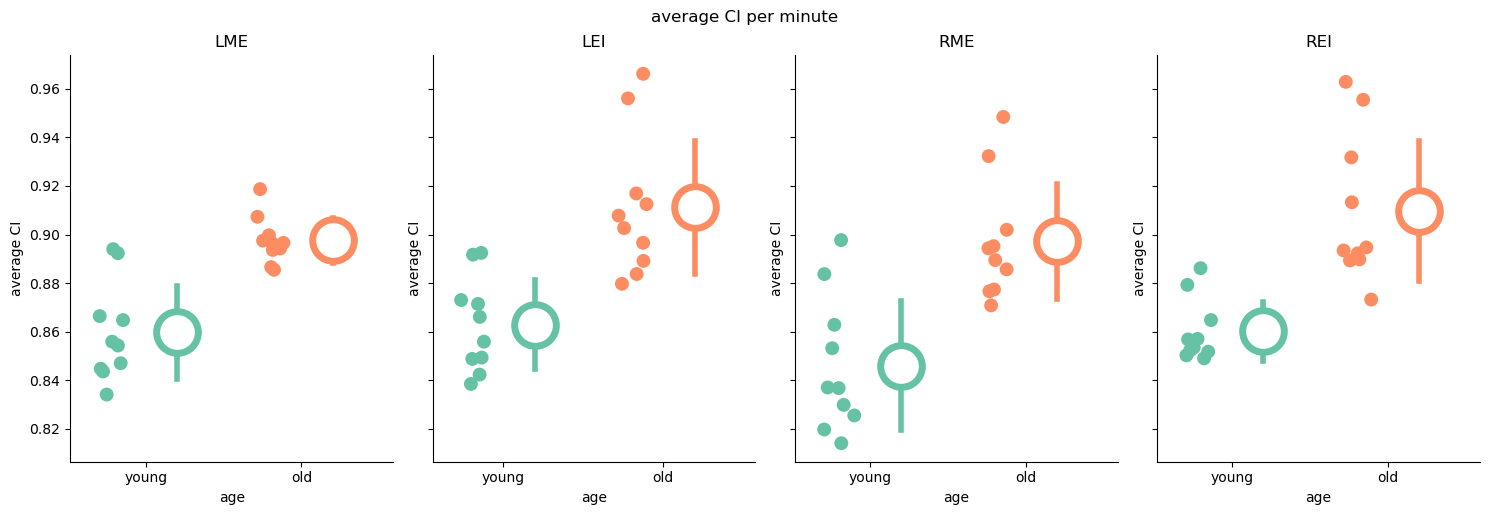

In [8]:
# Compare the young vs. old CI
# Two ways:
# One is resistive CI to all KCI (resistive are not significant though).
# Two, the percentage of the driving muscles over time (number of driving muscle-pairs per minute).

# This is only for average heatmap seen above and to provide some insight.
# We can only look on the significant time-frames:
grp_sig_driving, grp_CI = [{a: {c: [] for c in CONDS} for a in SUBJS} for _ in range(2)]
mean_driving_index, mean_CI = [{a: {c: 0 for c in CONDS} for a in SUBJS} for _ in range(2)]
sig_driving_index = pd.DataFrame()
for i, c in enumerate(CONDS):
    for a in SUBJS:
        grp_sig_driving[a][c] = np.count_nonzero(sigmaps_num[a][c], axis=0)
        mean_driving_index[a][c] = np.mean(grp_sig_driving[a][c])
        temp_map = ci_maps[a][c].copy()
        grp_CI[a][c] = np.sum(temp_map, axis=0) / 12
        mean_CI[a][c] = np.mean(grp_CI[a][c])

# to get the stats and plots for the driving muscle pairs, replace grp_CI below to grp_sig_driving
    sig_driving_index = pd.concat(
        [sig_driving_index, pg.ttest(grp_CI['young'][c], grp_CI['old'][c], alternative='less')],
        ignore_index=True
    )
    sig_driving_index.loc[i, 'condition'] = c

if save_stats:
    with pd.ExcelWriter(DATA_PATH + 'group_response/number_of_driving_pairs_per_min.xlsx') as writer:
        sig_driving_index.to_excel(writer, sheet_name='unpaired_ttest')

fig, ax = plt.subplots(1, len(CONDS), sharey=True, figsize=(15, 5))
for i, c in enumerate(CONDS):
    box_data = pd.DataFrame(grp_CI['young'][c], columns=['average CI'])
    box_data['age'] = 'young'
    box_data = pd.concat(
        [box_data, pd.DataFrame(grp_CI['old'][c], columns=['average CI'])], ignore_index=True)
    box_data.loc[box_data['age'] != 'young', 'age'] = 'old'
    lnd.lnd(data=box_data, y='average CI', x='age', ax=ax[i], palette='Set2', adtnl_space=0.2,
            mean_size=0.3, size=10, lw=4)
    ax[i].set_title(c)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

fig.tight_layout()
fig.suptitle('average CI per minute', y=1.02)
if not plot_fig:
    plt.close(fig)
if save_fig:
    fig.savefig(DATA_PATH + 'group_response/averageCI_per_min.pdf', bbox_inches='tight')

In [9]:
# Weight normalization
# Part of the smoothing was to find the weight of each data point, so, we cant' just add them together and make an
#  average. First we need to embed the weights into the CI values.

normal_average = {a: {c: np.zeros([len(SUBJS[a]), len(TP_NAMES) * len(TESTS), NUM_COL]) for c in CONDS}
                  for a in SUBJS}


def normalize_by_weight(data, weights, groups, axis=0):
    for g in groups:
        data[g] = data[g] * weights[g] / np.tile(
            np.sum(weights[g], axis=axis), [data[g].shape[axis], 1]) * data[g].shape[axis]
    return data


for k, t in enumerate(TESTS):
    for a in SUBJS:
        for c in CONDS:
            count = 0
            for b in BLOCKS:
                if b != 'catch':
                    temp_average = normalize_by_weight(
                        sm_data[t][a][c][b], sm_weights[t][a][c][b], groups=TP_NAMES, axis=0)
                    for i, p in enumerate(TP_NAMES):
                        for j in range(temp_average[p].shape[0]):
                            normal_average[a][c][j, i + len(TP_NAMES) * k,
                                                 count: count + DES_POINTS[b]] = temp_average[p][j, :]
                    count += DES_POINTS[b]
            normal_average[a][c][normal_average[a][c] == 0] = np.nan

/opt/homebrew/anaconda3/envs/torch-beta/lib/python3.9/site-packages/numpy/core/shape_base.py:65: UserWarning:




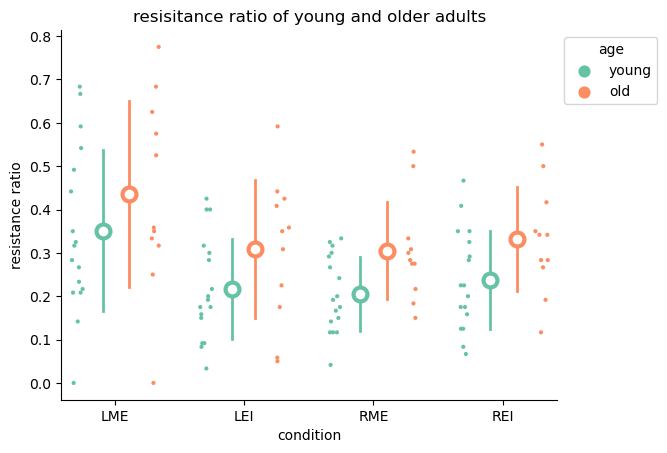

In [10]:
# Collapse over muscles (and then over time)
# We can try to find the resiting ratio for 1- each time-frame and then 2- for the overall. This way, we only collapse
# the muscles, not the time
resisting_ratio = {a: {c: np.zeros((normal_average[a][c].shape[0], normal_average[a][c].shape[2])) for c in CONDS}
                   for a in SUBJS}
accum_ratio = {a: {c: [] for c in CONDS} for a in SUBJS}
for c in CONDS:
    for a in SUBJS:
        resisting_ratio[a][c] = np.count_nonzero(normal_average[a][c] > 1, axis=1) / (
            np.ones_like(resisting_ratio[a][c]) * normal_average[a][c].shape[1])
        accum_ratio[a][c] = np.nanmean(resisting_ratio[a][c], axis=1)

accum_ratio_stats = pd.DataFrame()  # also crushed time, only one value per subject
for i, c in enumerate(CONDS):
    accum_ratio_stats = pd.concat([accum_ratio_stats, pg.ttest(
        accum_ratio['young'][c], accum_ratio['old'][c], alternative='less', correction=False)], ignore_index=True
    )
    accum_ratio_stats.loc[i, 'condition'] = c

ratio_stats = pd.DataFrame()
for i, c in enumerate(CONDS):
    for n in range(NUM_COL):
        temp_test = pg.ttest(
            resisting_ratio['young'][c][:, n], resisting_ratio['old'][c][:, n], alternative='less', correction=False)
        ratio_stats = pd.concat([ratio_stats, temp_test], ignore_index=True)
        ratio_stats.loc[i * NUM_COL + n, 'condition'] = f"{c}_{n}"

if save_stats:
    with pd.ExcelWriter(DATA_PATH + 'group_response/resistance_ratio_stats.xlsx') as writer:
        accum_ratio_stats.to_excel(writer, sheet_name='accum_test')
        ratio_stats[ratio_stats['p-val'] < 0.1].to_excel(writer, sheet_name='perminute_test')


# %% plot it
# plot the accumulated stats
box_data = pd.DataFrame(accum_ratio['young'])
box_data['age'] = 'young'
box_data = pd.concat([box_data, pd.DataFrame(accum_ratio['old'])], ignore_index=True)
box_data.loc[box_data['age'] != 'young', 'age'] = 'old'
adtnl_space = 0.1
fig, ax = plt.subplots(1, 1)
lnd.lnd(
    data=box_data.melt(id_vars=['age'], value_vars=CONDS, var_name='condition', value_name='resistance ratio'),
    x='condition', y='resistance ratio', hue='age', palette='Set2', size=3, ax=ax
)
ax.set_title('resisitance ratio of young and older adults')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
if not plot_fig:
    plt.close(fig)
if save_fig:
    fig.savefig(DATA_PATH + 'group_response/accumulated_resistance_ratio_by_age.jpg', bbox_inches='tight')

# plotly implementation (harder to implement subplots)
# fig = px.box(
#     box_data.melt(id_vars=['age'], value_vars=CONDS, var_name='condition', value_name='resistance ratio'),
#     x='condition', y='resistance ratio', color='age',
#     title='accumulated resistance ratio by age')
# if plot_fig:
#     fig.show()
# if save_fig:
#     fig.write_image(DATA_PATH + 'group_response/accumulated_resistance_ratio_by_age.pdf')

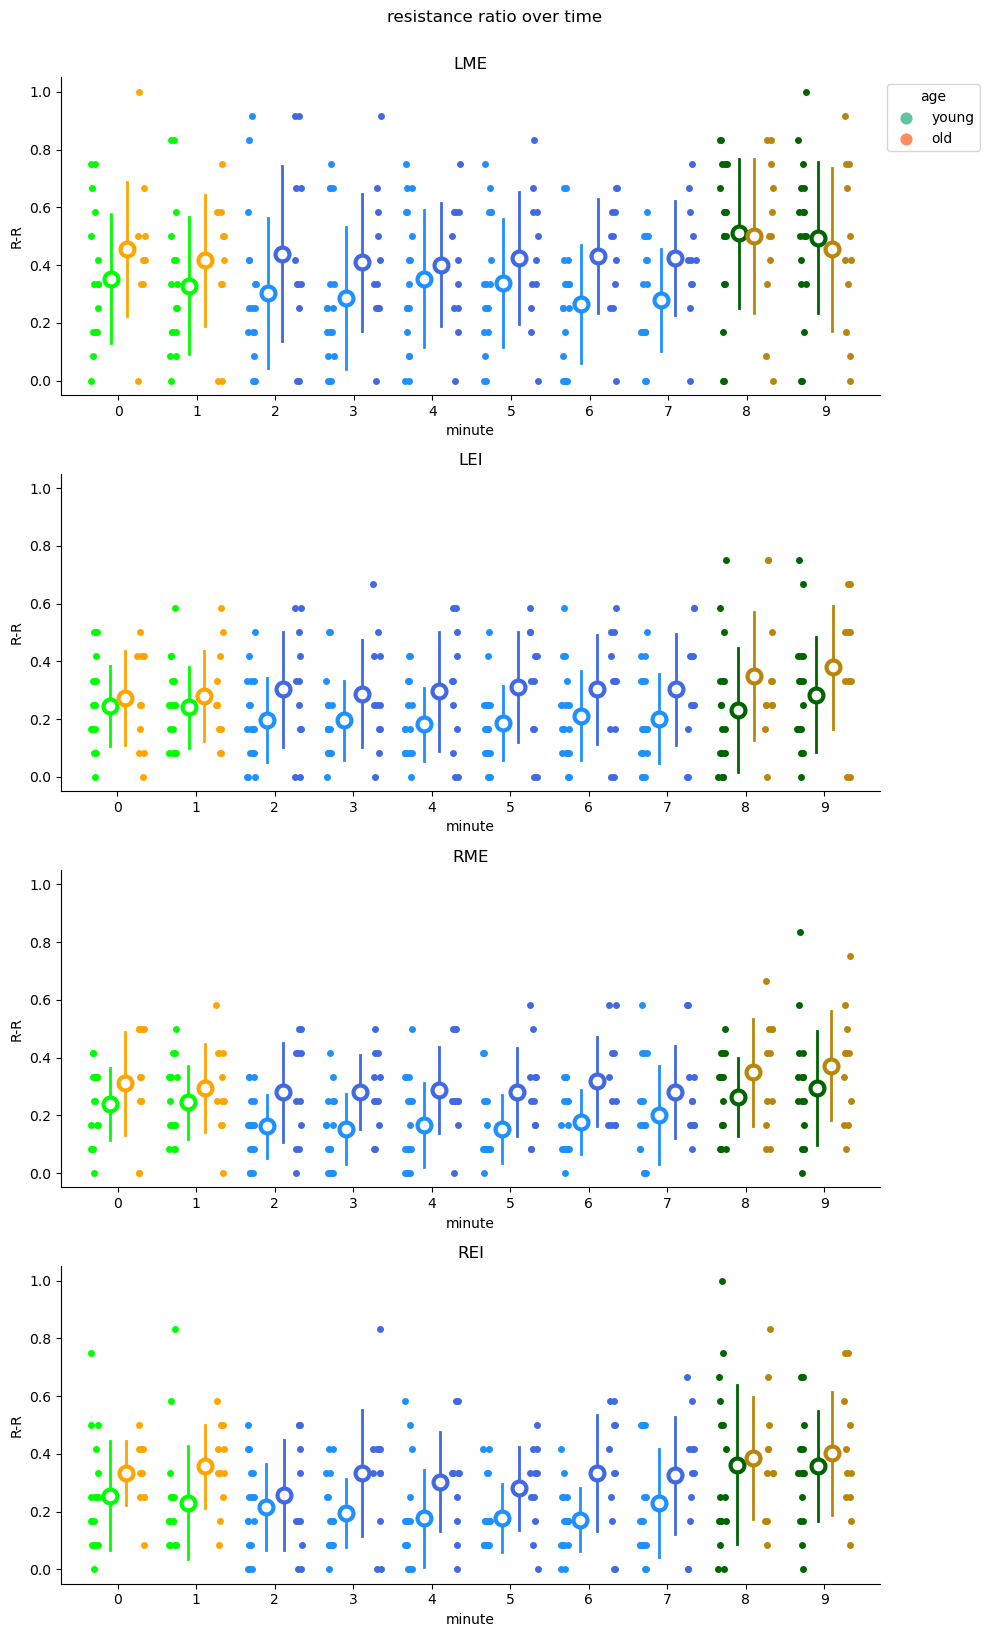

In [12]:
# Plot the temporal comparison.
l_color = {a: [] for a in SUBJS}
l_color['young'] = {'pre': rgb('lime'), 'pert': rgb('dodgerblue'), 'catch': rgb('deeppink'), 'post': rgb('darkgreen')}
l_color['old'] = {'pre': rgb('orange'), 'pert': rgb('royalblue'), 'catch': rgb('darkviolet'),
                  'post': rgb('darkgoldenrod')}
plot_colors = {'young':
               np.concatenate((
                   np.tile(l_color['young']['pre'], (2, 1)),
                   np.tile(l_color['young']['pert'], (6, 1)),
                   np.tile(l_color['young']['post'], (2, 1))), axis=0),
               'old':
               np.concatenate((
                   np.tile(l_color['old']['pre'], (2, 1)),
                   np.tile(l_color['old']['pert'], (6, 1)),
                   np.tile(l_color['old']['post'], (2, 1))), axis=0)}

box_data = {c: [] for c in CONDS}
fig, ax = plt.subplots(len(CONDS), 1, sharey=True, figsize=(10, 16))
for i, c in enumerate(CONDS):
    box_data[c] = pd.DataFrame(resisting_ratio['young'][c])
    box_data[c]['age'] = 'young'
    box_data[c] = pd.concat([box_data[c], pd.DataFrame(resisting_ratio['old'][c])], ignore_index=True)
    box_data[c].loc[box_data[c]['age'] != 'young', 'age'] = 'old'
    lnd.lnd(
        data=box_data[c].melt(id_vars=['age'], value_vars=list(range(NUM_COL)), var_name='minute', value_name='R-R'),
        x='minute', y='R-R', hue='age', palette='Set2', ax=ax[i], size=5, lw=2, colors=plot_colors
    )
    sns.move_legend(ax[i], 'upper left', bbox_to_anchor=(1, 1))
    ax[i].set_title(c)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].get_legend().set_visible(False)
    if i == 0:
        ax[i].get_legend().set_visible(True)
fig.tight_layout()
fig.suptitle('resistance ratio over time', y=1.02)
if not plot_fig:
    plt.close(fig)
if save_fig:
    fig.savefig(DATA_PATH + 'group_response/resistance_ratio_by_time_and_age.pdf', bbox_inches='tight')